# Lagrange Model for Total Eenergy

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# load dataset
# add a new column 'Bird(m/s)'*'Blade(rad/s)' as BirdxBlade
data_raw = pd.read_csv('LagrangeJournalBirdStrikeValueupto50.csv') 
data_raw['BirdxBlade'] = data_raw['Bird(m/s)'] * data_raw['Blade(rad/s)'] 
data_raw['Bird^2'] = data_raw['Bird(m/s)'] ** 2
data_raw['Blade^2'] = data_raw['Blade(rad/s)'] ** 2

In [4]:
data_raw.describe()

,test_set,Bird(m/s),Blade(rad/s),Max_TD(mm),Von_Mises_Stress(pascal),Total_Energy,BirdxBlade,Bird^2,Blade^2
count,49.00000,49.000000,49.000000,49.000000,4.900000e+01,4.900000e+01,49.000000,49.000000,49.000000
mean,25.00000,182.500000,515.000000,0.670000,1.167274e+09,1.821396e+06,96487.500000,34556.250000,270225.000000
std,14.28869,35.721725,71.443451,0.188392,4.449917e+07,5.044295e+05,31516.098317,13087.211225,73725.175907
min,1.00000,122.500000,395.000000,0.350000,1.059400e+09,1.037200e+06,48387.500000,15006.250000,156025.000000
25%,13.00000,152.500000,455.000000,0.490000,1.151850e+09,1.390000e+06,69387.500000,23256.250000,207025.000000
50%,25.00000,182.500000,515.000000,0.740000,1.172436e+09,1.787100e+06,93987.500000,33306.250000,265225.000000
75%,37.00000,212.500000,575.000000,0.830000,1.195846e+09,2.234322e+06,122187.500000,45156.250000,330625.000000
max,49.00000,242.500000,635.000000,0.950000,1.276456e+09,2.731651e+06,153987.500000,58806.250000,403225.000000


# Colinearity test

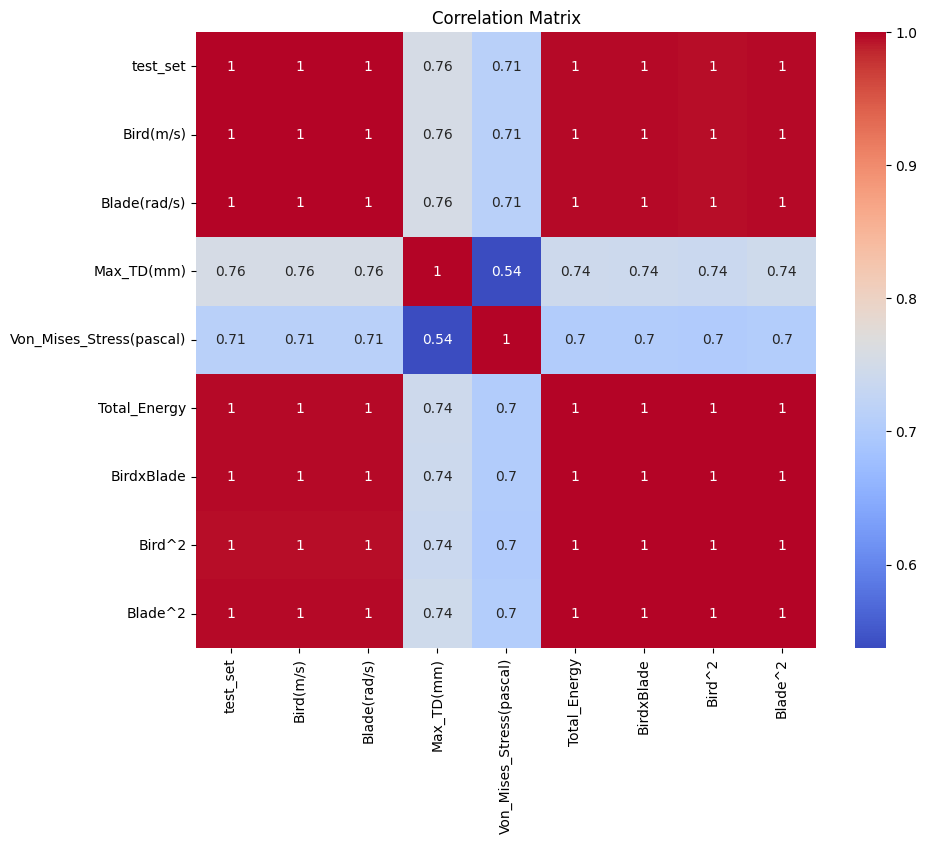

In [5]:
# Plot the correlation matrix
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
correlation_matrix = data_raw.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Plot outputs for Total_Energy

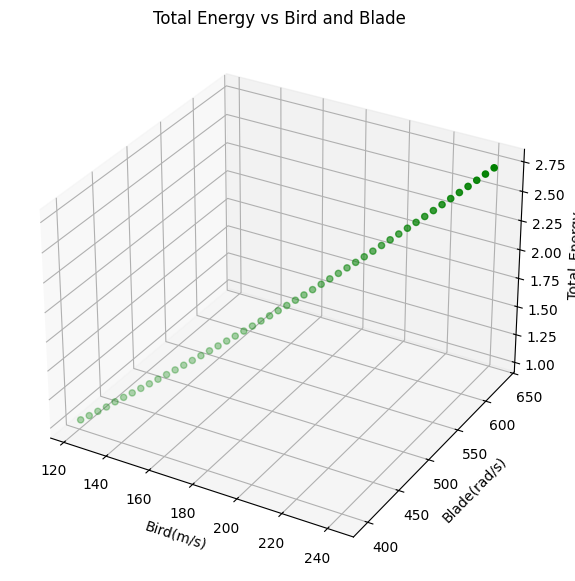

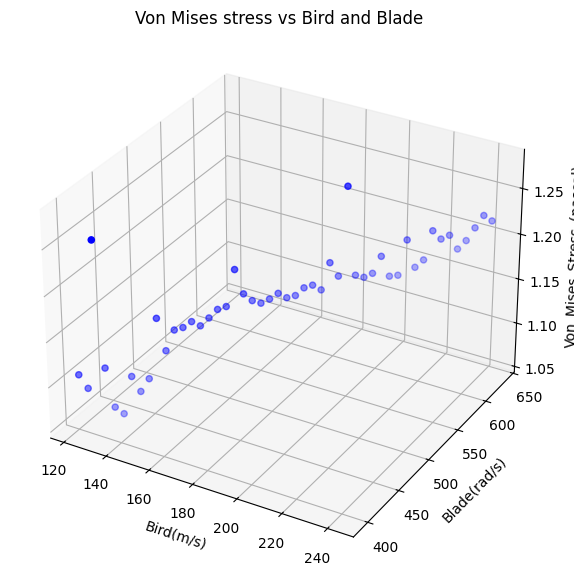

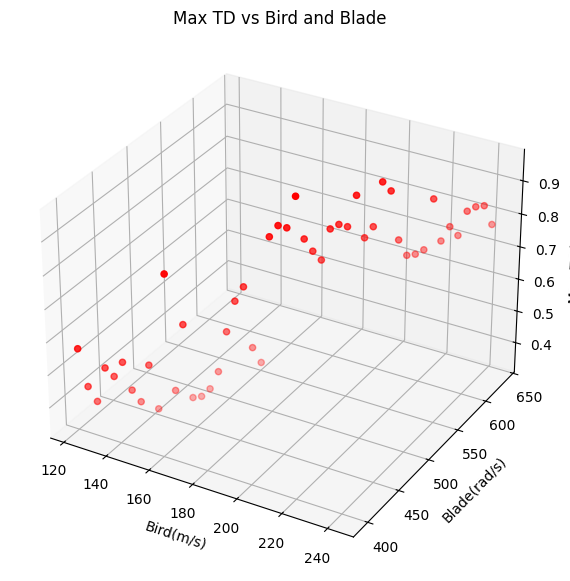

In [6]:
# plot Total Energy vs Bird and Blade
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_raw['Bird(m/s)'], data_raw['Blade(rad/s)'], data_raw['Total_Energy'], c='g', marker='o')
ax.set_title('Total Energy vs Bird and Blade')
ax.set_xlabel('Bird(m/s)')
ax.set_ylabel('Blade(rad/s)')
ax.set_zlabel('Total_Energy')
plt.show()

# plot Von Mises Stress vs Bird and Blade
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_raw['Bird(m/s)'], data_raw['Blade(rad/s)'], data_raw['Von_Mises_Stress(pascal)'], c='b', marker='o')
ax.set_title('Von Mises stress vs Bird and Blade')
ax.set_xlabel('Bird(m/s)')
ax.set_ylabel('Blade(rad/s)')
ax.set_zlabel('Von_Mises_Stress_(pascal)')
plt.show()

# plot Max TD vs Bird and Blade
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_raw['Bird(m/s)'], data_raw['Blade(rad/s)'], data_raw['Max_TD(mm)'], c='r', marker='o')
ax.set_title('Max TD vs Bird and Blade')
ax.set_xlabel('Bird(m/s)')
ax.set_ylabel('Blade(rad/s)')
ax.set_zlabel('Max_TD(mm)')
plt.show()

# 1. Random Forest Regressor (RF)

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = data_raw[['Bird(m/s)', 'Blade(rad/s)','BirdxBlade','Bird^2','Blade^2']]
y = pd.DataFrame({
    'Max_TD_mm': data_raw['Max_TD(mm)'],
    'Von_Mises_Stress_MPa': data_raw['Von_Mises_Stress(pascal)'] / 1e6,
    'Total_Energy_kJ': data_raw['Total_Energy'] / 1000
}) # Convert to kJ

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=25,
    random_state=42,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=2,
    n_jobs=-1,
    max_features='sqrt'
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regression Results:")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"MSE  : {mse:.4f}")

print ("\n k mean cross validation \n")

# Do K mean cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
    n_estimators=25,
    random_state=42,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=2,
    n_jobs=-1,
    max_features='sqrt'
    )
    
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf = rf_model_kf.predict(X_test_kf)
    
    mse_kf = mean_squared_error(y_test_kf, y_pred_kf)
    r2_kf = r2_score(y_test_kf, y_pred_kf)
    rmse_kf = np.sqrt(mse_kf)
    rmse_list.append(rmse_kf)
average_rmse = np.mean(rmse_list)
print(f"Average RMSE from K-Fold CV: {average_rmse:.4f}")
print(f"RMSEs from each fold: {rmse_list}")
print(f"R²   : {r2_kf:.4f}")
print(f"MSE  : {mse_kf:.4f}")

# At fold 4 :
# likely at very high or very low speeds the model finds harder to predict.

# Feature imporatnace in number format
importances = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importance_df)



Random Forest Regression Results:
RMSE : 32.9316
R²   : 0.6340
MSE  : 1084.4920

 k mean cross validation 

Average RMSE from K-Fold CV: 29.8678
RMSEs from each fold: [np.float64(30.73604389923405), np.float64(22.90866999811615), np.float64(27.965873909750574), np.float64(39.93556482835858), np.float64(27.792729361217138)]
R²   : 0.8064
MSE  : 772.4358

Feature Importances:
        Feature  Importance
2    BirdxBlade    0.245016
4       Blade^2    0.220614
1  Blade(rad/s)    0.216964
0     Bird(m/s)    0.200937
3        Bird^2    0.116468


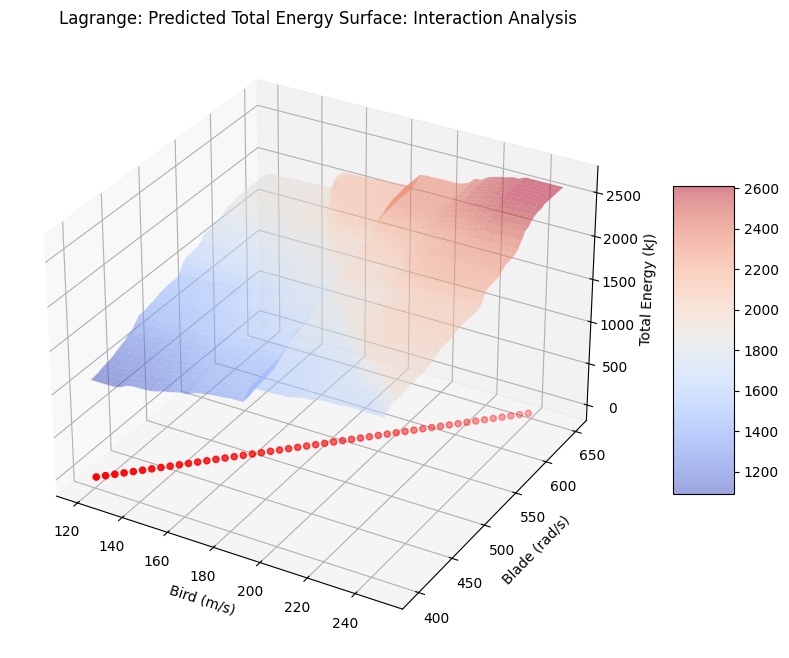

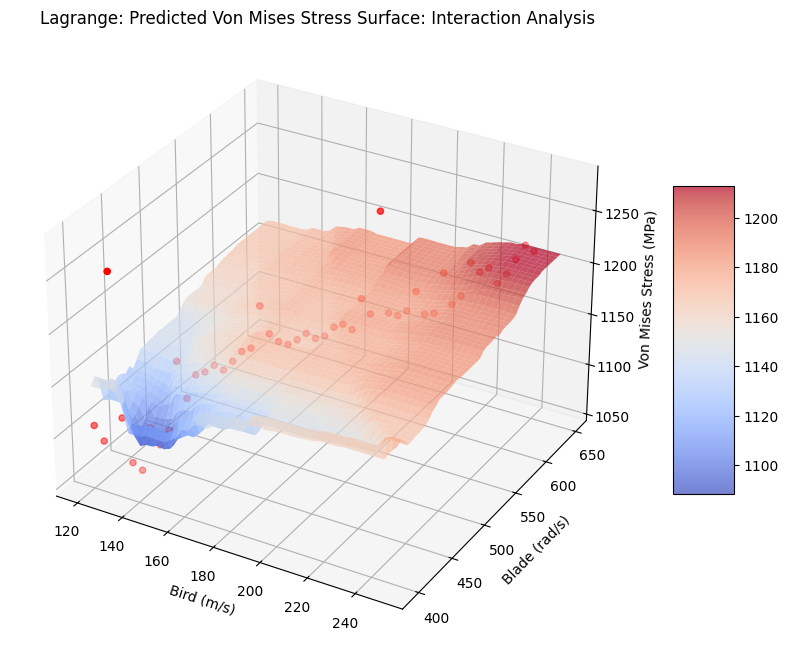

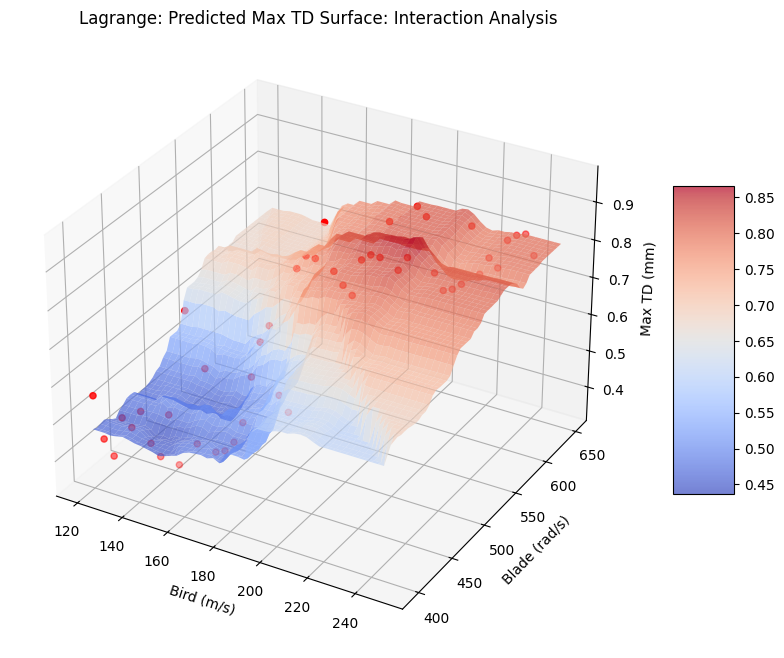

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# 1. Create a grid of values for Bird and Blade speeds
# Using the range observed in your 3D scatter plot (approx 120-250 and 400-650)
bird_range = np.linspace(120, 250, 50)
blade_range = np.linspace(400, 650, 50)
BIRD, BLADE = np.meshgrid(bird_range, blade_range)

# 2. Prepare the grid for prediction
# We must create the same 'BirdxBlade' feature used in your winning model
grid_df = pd.DataFrame({
    'Bird(m/s)': BIRD.ravel(),
    'Blade(rad/s)': BLADE.ravel(),
    'BirdxBlade': (BIRD * BLADE).ravel(),
    'Bird^2': (BIRD ** 2).ravel(),
    'Blade^2': (BLADE ** 2).ravel()
})
grid_df['BirdxBlade'] = grid_df['Bird(m/s)'] * grid_df['Blade(rad/s)']
grid_df['Bird^2'] = grid_df['Bird(m/s)'] ** 2
grid_df['Blade^2'] = grid_df['Blade(rad/s)'] ** 2

# 3. Predict Stress across the entire grid
# Using your rf_model 
Z_pred_all = rf_model.predict(grid_df)

# using Total_Energy_kJ
Z_pred_total = Z_pred_all[:, 2].reshape(BIRD.shape)

# 4. Plot the 3D Surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the predicted surface
surf = ax.plot_surface(BIRD, BLADE, Z_pred_total, cmap=cm.coolwarm, alpha=0.5, antialiased=True)

# Add your actual data points (red dots) to see how well they align
ax.scatter(data_raw['Bird(m/s)'], data_raw['Blade(rad/s)'], data_raw['Total_Energy'] / 1e6, c='red', marker='o', label='Actual Data')
ax.set_xlabel('Bird (m/s)')
ax.set_ylabel('Blade (rad/s)')
ax.set_zlabel('Total Energy (kJ)')
ax.set_title('Lagrange: Predicted Total Energy Surface: Interaction Analysis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# using Von_Mises_Stress_MPa
Z_pred_stress = Z_pred_all[:, 1].reshape(BIRD.shape)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the predicted surface
surf = ax.plot_surface(BIRD, BLADE, Z_pred_stress, cmap=cm.coolwarm, alpha=0.7, antialiased=True)
# Add your actual data points (red dots) to see how well they align
ax.scatter(data_raw['Bird(m/s)'], data_raw['Blade(rad/s)'], data_raw['Von_Mises_Stress(pascal)'] / 1e6, c='red', marker='o', label='Actual Data')
ax.set_xlabel('Bird (m/s)')
ax.set_ylabel('Blade (rad/s)')
ax.set_zlabel('Von Mises Stress (MPa)')
ax.set_title('Lagrange: Predicted Von Mises Stress Surface: Interaction Analysis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# using Max_TD_mm
Z_pred_td = Z_pred_all[:, 0].reshape(BIRD.shape)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the predicted surface
surf = ax.plot_surface(BIRD, BLADE, Z_pred_td, cmap=cm.coolwarm, alpha=0.7, antialiased=True)
# Add your actual data points (red dots) to see how well they align
ax.scatter(data_raw['Bird(m/s)'], data_raw['Blade(rad/s)'], data_raw['Max_TD(mm)'], c='red', marker='o', label='Actual Data')
ax.set_xlabel('Bird (m/s)')
ax.set_ylabel('Blade (rad/s)')
ax.set_zlabel('Max TD (mm)')
ax.set_title('Lagrange: Predicted Max TD Surface: Interaction Analysis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()



In [9]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Surface(
        x=bird_range,
        y=blade_range,
        z=Z_pred_td,
        colorscale='Viridis',
        opacity=0.7,
        name='Predicted Surface'
    ),
    go.Scatter3d(
        x=data_raw['Bird(m/s)'],
        y=data_raw['Blade(rad/s)'],
        z=data_raw['Max_TD(mm)'],
        mode='markers',
        marker=dict(size=5, color='red'),
        name='Actual Data'
    )
])

fig.update_layout(
    title='Lagrange: Predicted Max TD Surface: Interaction Analysis',
    scene=dict(
        xaxis_title='Bird (m/s)',
        yaxis_title='Blade (rad/s)',
        zaxis_title='Max TD (mm)'
    )
)
fig.show()

# SVR with RBF 

In [10]:

# SVR only supports single-output regression, so we fit one model per target
targets = y.columns
results = {}

for target in targets:
    # Split data into training and testing sets for this target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_scaled = StandardScaler().fit_transform(X_train)
    X_test_scaled = StandardScaler().fit_transform(X_test)

    y_train_target = y_train[target]
    y_test_target = y_test[target]

    # Train SVR model
    model = SVR(kernel='rbf', C=160, gamma= 0.1, epsilon=0.1)
    model.fit(X_train_scaled, y_train_target)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate model
    mse_svr = mean_squared_error(y_test_target, y_pred)
    rmse_svr = np.sqrt(mse_svr)
    r2_svr = r2_score(y_test_target, y_pred)

    print(f"\nResults for {target}:")
    print(f'Mean Squared Error: {mse_svr:.4f}')
    print(f'RMSE: {rmse_svr:.4f}')
    print(f'R² Score: {r2_svr:.4f}')

    # K-Fold cross-validation for SVR
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list_svr = []
    for train_index, test_index in kf.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]

        # Standardize features for each fold
        scaler_kf = StandardScaler()
        X_train_kf_scaled = scaler_kf.fit_transform(X_train_kf)
        X_test_kf_scaled = scaler_kf.transform(X_test_kf)

        svr_model_kf = SVR(kernel='rbf', C=160, gamma=1, epsilon=0.1)
        svr_model_kf.fit(X_train_kf_scaled, y_train_kf)
        y_pred_kf_svr = svr_model_kf.predict(X_test_kf_scaled)

        mse_kf_svr = mean_squared_error(y_test_kf, y_pred_kf_svr)
        rmse_kf_svr = np.sqrt(mse_kf_svr)
        rmse_list_svr.append(rmse_kf_svr)
    average_rmse_svr = np.mean(rmse_list_svr)
    print(f"Average MSE from K-Fold CV (SVR): {average_rmse_svr:.4f}")
    print(f"MSEs from each fold (SVR): {rmse_list_svr}")
    print(f"K fold R²   : {r2_svr:.4f}")

# Feature importance is not directly available for SVR models


Results for Max_TD_mm:
Mean Squared Error: 0.0335
RMSE: 0.1830
R² Score: -0.3710
Average MSE from K-Fold CV (SVR): 0.1127
MSEs from each fold (SVR): [np.float64(0.10985617733210185), np.float64(0.07781884585700548), np.float64(0.13511649463624148), np.float64(0.16187166535619227), np.float64(0.078734713009413)]
K fold R²   : -0.3710

Results for Von_Mises_Stress_MPa:
Mean Squared Error: 1890.5737
RMSE: 43.4807
R² Score: -0.5153
Average MSE from K-Fold CV (SVR): 29.3434
MSEs from each fold (SVR): [np.float64(31.17638610258442), np.float64(16.763097662268994), np.float64(22.851149491106792), np.float64(55.942659912377074), np.float64(19.983854168641738)]
K fold R²   : -0.5153

Results for Total_Energy_kJ:
Mean Squared Error: 60426.1774
RMSE: 245.8174
R² Score: 0.6821
Average MSE from K-Fold CV (SVR): 89.4211
MSEs from each fold (SVR): [np.float64(124.84251391642132), np.float64(40.586969126546094), np.float64(79.52389654722069), np.float64(83.36742376202916), np.float64(118.784881303835

# Polynomial Regression

In [11]:
# polynomial regression only supports single-output regression, so we fit one model per target
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
targets = y.columns
for target in targets:
    # Split data into training and testing sets for this target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_scaled = StandardScaler().fit_transform(X_train)
    X_test_scaled = StandardScaler().fit_transform(X_test)

    y_train_target = y_train[target]
    y_test_target = y_test[target]

    # Create polynomial features
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Train polynomial regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_target)

    # Make predictions
    y_pred = model.predict(X_test_poly)

    # Evaluate model
    mse_poly = mean_squared_error(y_test_target, y_pred)
    rmse_poly = np.sqrt(mse_poly)
    r2_poly = r2_score(y_test_target, y_pred)

    print(f"\nPolynomial Regression Results for {target}:")
    print(f'Mean Squared Error: {mse_poly:.4f}')
    print(f'RMSE: {rmse_poly:.4f}')
    print(f'R² Score: {r2_poly:.4f}')
    # K-Fold cross-validation for Polynomial Regression
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list_poly = []
    for train_index, test_index in kf.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]

        # Standardize features for each fold
        scaler_kf = StandardScaler()
        X_train_kf_scaled = scaler_kf.fit_transform(X_train_kf)
        X_test_kf_scaled = scaler_kf.transform(X_test_kf)

        # Create polynomial features
        poly_kf = PolynomialFeatures(degree=2)
        X_train_kf_poly = poly_kf.fit_transform(X_train_kf_scaled)
        X_test_kf_poly = poly_kf.transform(X_test_kf_scaled)

        poly_model_kf = LinearRegression()
        poly_model_kf.fit(X_train_kf_poly, y_train_kf)
        y_pred_kf_poly = poly_model_kf.predict(X_test_kf_poly)

        mse_kf_poly = mean_squared_error(y_test_kf, y_pred_kf_poly)
        rmse_kf_poly = np.sqrt(mse_kf_poly)
        rmse_list_poly.append(rmse_kf_poly)
    average_rmse_poly = np.mean(rmse_list_poly)
    print(f"Average MSE from K-Fold CV (Polynomial Regression): {average_rmse_poly:.4f}")
    print(f"MSEs from each fold (Polynomial Regression): {rmse_list_poly}")
    print(f"K fold R²   : {r2_poly:.4f}")

    


Polynomial Regression Results for Max_TD_mm:
Mean Squared Error: 0.0076
RMSE: 0.0872
R² Score: 0.7693
Average MSE from K-Fold CV (Polynomial Regression): 0.1019
MSEs from each fold (Polynomial Regression): [np.float64(0.08188424967436762), np.float64(0.08794910626267316), np.float64(0.07562716719024408), np.float64(0.1614229837039113), np.float64(0.1027427274076151)]
K fold R²   : 0.7693

Polynomial Regression Results for Von_Mises_Stress_MPa:
Mean Squared Error: 1255.2468
RMSE: 35.4295
R² Score: -0.7698
Average MSE from K-Fold CV (Polynomial Regression): 31.6683
MSEs from each fold (Polynomial Regression): [np.float64(30.341614278497577), np.float64(24.035670118037583), np.float64(28.494315960578017), np.float64(53.5225191702816), np.float64(21.94723676604146)]
K fold R²   : -0.7698

Polynomial Regression Results for Total_Energy_kJ:
Mean Squared Error: 152692.5553
RMSE: 390.7589
R² Score: 0.5087
Average MSE from K-Fold CV (Polynomial Regression): 0.8968
MSEs from each fold (Polynomi

# XG Boost

In [12]:
# XGBoost only supports single-output regression, so we fit one model per target
import xgboost as xgb
targets = y.columns
for target in targets:
    # Split data into training and testing sets for this target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_scaled = StandardScaler().fit_transform(X_train)
    X_test_scaled = StandardScaler().fit_transform(X_test)

    y_train_target = y_train[target]
    y_test_target = y_test[target]

    # Train XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train_scaled, y_train_target)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate model
    mse_xgb = mean_squared_error(y_test_target, y_pred)
    rmse_xgb = np.sqrt(mse_xgb)
    r2_xgb = r2_score(y_test_target, y_pred)

    print(f"\nXGBoost Results for {target}:")
    print(f'Mean Squared Error: {mse_xgb:.4f}')
    print(f'RMSE: {rmse_xgb:.4f}')
    print(f'R² Score: {r2_xgb:.4f}')
    # K-Fold cross-validation for XGBoost
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list_xgb = []
    for train_index, test_index in kf.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]

        # Standardize features for each fold
        scaler_kf = StandardScaler()
        X_train_kf_scaled = scaler_kf.fit_transform(X_train_kf)
        X_test_kf_scaled = scaler_kf.transform(X_test_kf)

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        xgb_model_kf.fit(X_train_kf_scaled, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf_scaled)

        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
    average_rmse_xgb = np.mean(rmse_list_xgb)
    print(f"Average MSE from K-Fold CV (XGBoost): {average_rmse_xgb:.4f}")
    print(f"MSEs from each fold (XGBoost): {rmse_list_xgb}")
    print(f"K fold R²   : {r2_xgb:.4f}")

# Feature importance for XGBoost
    importance = model.feature_importances_
    feature_names = X.columns
    feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)
    print("\nXGBoost Feature Importances:")
    print(feature_importance_df_xgb)

    


XGBoost Results for Max_TD_mm:
Mean Squared Error: 0.0096
RMSE: 0.0980
R² Score: 0.7083
Average MSE from K-Fold CV (XGBoost): 0.1151
MSEs from each fold (XGBoost): [np.float64(0.09099354301934073), np.float64(0.09937737638347127), np.float64(0.08076744417272289), np.float64(0.15496543292318868), np.float64(0.14939126737550085)]
K fold R²   : 0.7083

XGBoost Feature Importances:
        Feature  Importance
0     Bird(m/s)         1.0
1  Blade(rad/s)         0.0
2    BirdxBlade         0.0
3        Bird^2         0.0
4       Blade^2         0.0

XGBoost Results for Von_Mises_Stress_MPa:
Mean Squared Error: 2695.3023
RMSE: 51.9163
R² Score: -2.8001
Average MSE from K-Fold CV (XGBoost): 45.1488
MSEs from each fold (XGBoost): [np.float64(32.451632252086675), np.float64(75.36135580336384), np.float64(49.42586237065043), np.float64(48.832052013836645), np.float64(19.673121574774864)]
K fold R²   : -2.8001

XGBoost Feature Importances:
        Feature  Importance
0     Bird(m/s)         1.0
1